<a href="https://colab.research.google.com/github/jblcky/retail-inventory-forecasting-2/blob/main/notebooks/model_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Model Preparation**
- import library
- pandas, numpy → for data wrangling
- sklearn modules → used for data preprocessing, model building, and saving pipelines
- joblib → saves your trained model and preprocessing pipeline for future reuse

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib


In [2]:
url = 'https://raw.githubusercontent.com/jblcky/retail-inventory-forecasting-2/refs/heads/main/data/processed/sales_df_fe.csv'
# Load processed file
sales_df = pd.read_csv(url, parse_dates=["date"])

**Define Features and Target**
- features: Includes temporal, product, price, and event-based drivers of demand.
- target: We're predicting quantity_sold — you can later extend this to predict revenue, stockout_risk, etc.

In [3]:
features = [
    'store_id', 'sku_id', 'day_of_week', 'weekofyear', 'month', 'year',
    'is_weekend', 'is_holiday', 'is_school_holiday', 'is_flu_season',
    'price', 'on_promo', 'days_to_expiry', 'rolling_7d_sales'
]

target = 'quantity_sold'


print to verify

In [4]:
sales_df[features + [target]].head()


,store_id,sku_id,day_of_week,weekofyear,month,year,is_weekend,is_holiday,is_school_holiday,is_flu_season,price,on_promo,days_to_expiry,rolling_7d_sales,quantity_sold
0,Store_A,SKU_001,0,1,1,2024,False,True,False,False,16.236204,0,999,0.0,45
1,Store_A,SKU_001,1,1,1,2024,False,False,False,False,33.521429,0,999,0.0,51
2,Store_A,SKU_001,2,1,1,2024,False,False,False,False,26.959818,0,999,0.0,51
3,Store_A,SKU_001,3,1,1,2024,False,False,False,False,22.959755,0,999,0.0,57
4,Store_A,SKU_001,4,1,1,2024,False,False,False,False,9.680559,0,999,0.0,46


In [5]:
X = sales_df[features]
y = sales_df[target]

Train-Test Split (Time-Aware)
- Time-based split avoids "peeking into the future," which would make the model unrealistically good.

- This simulates real-world deployment: train on past, test on unseen future.

- This avoids data leakage by ensuring test data is after train data chronologically.

In [6]:
# Sort by date to simulate real-world forecasting
sales_df = sales_df.sort_values('date')

# Use 80% for training, 20% for testing
split_idx = int(len(sales_df) * 0.8)
train_df = sales_df.iloc[:split_idx]
test_df = sales_df.iloc[split_idx:]

# Split into X and y
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]


Preprocessing Pipeline
- StandardScaler() → scales numeric columns to mean=0, std=1 for better model performance.

- OneHotEncoder() → turns categorical features into binary vectors (e.g., day_of_week=Mon becomes [1, 0, 0, 0, 0, 0, 0])

- ColumnTransformer → applies these operations column-wise cleanly.

In [7]:
categorical = ['store_id', 'sku_id', 'day_of_week', 'month']
numeric = ['price', 'days_to_expiry']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])


Build a Modeling Pipeline (with XGBoost)
- Pipeline chains preprocessing + modeling into one clean object.

- XGBRegressor is fast, robust to overfitting, and handles missing values (if any).

- You can easily swap models later (e.g., LightGBM or RandomForest).


In [8]:
from xgboost import XGBRegressor

xgb_model = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        random_state=42
    ))
])


Train the Model
- Trains the full pipeline: first transforms the data, then fits the model.

- You can now evaluate predictions using xgb_model.predict(X_test).

In [9]:
xgb_model.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['price', 'days_to_expiry']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['store_id', 'sku_id',
                                                   'day_of_week', 'month'])])),
                ('regressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, devic...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=100, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [10]:
xgb_model.predict(X_test)

array([50.875145 , 19.460707 , 23.737192 , 14.856979 , 52.748486 ,
       49.00493  , 46.733208 , 53.158188 , 44.609833 , 28.534958 ,
       30.915201 , 26.085361 , 58.291916 , 41.867607 , 36.45849  ,
       13.51506  , 22.335922 , 35.991623 , 14.690967 , 23.316788 ,
       46.72619  , 13.135737 , 51.45553  , 49.04976  , 14.710263 ,
       25.118704 , 28.453896 , 21.700916 , 45.30085  , 22.472794 ,
       15.736778 , 43.535618 , 39.29026  , 36.023067 , 34.953182 ,
       23.102737 , 57.75875  , 21.09576  , 57.78308  , 29.562729 ,
       38.992767 , 46.71915  , 51.242126 , 29.461454 , 13.196    ,
       25.675352 , 21.914114 , 30.664104 , 46.79579  , 14.679627 ,
       22.760607 , 22.41046  , 37.182503 , 32.196358 , 60.10625  ,
       18.878027 , 55.37105  , 45.092133 , 51.199753 , 15.858112 ,
       13.003167 , 52.20469  , 59.539314 , 35.396866 , 24.662302 ,
       29.24583  , 22.511642 , 49.158566 , 40.392315 , 20.434624 ,
       14.154796 , 14.016651 , 47.30689  , 29.925264 , 21.9485

Linear Regression – Basic Model
- Why Linear Regression? It's a fast, interpretable baseline. If it performs reasonably well, it means your features already carry useful signal.

- RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) are commonly used metrics for regression problems — lower is better.


In [14]:
X_train.head(10)

,store_id,sku_id,day_of_week,weekofyear,month,year,is_weekend,is_holiday,is_school_holiday,is_flu_season,price,on_promo,days_to_expiry,rolling_7d_sales
0,Store_A,SKU_001,0,1,1,2024,False,True,False,False,16.236204,0,999,0.0
2160,Store_A,SKU_007,0,1,1,2024,False,True,False,False,24.534428,0,999,0.0
540,Store_B,SKU_002,0,1,1,2024,False,True,False,False,33.621531,0,999,0.0
1980,Store_B,SKU_006,0,1,1,2024,False,True,False,False,10.583043,0,999,0.0
1080,Store_A,SKU_004,0,1,1,2024,False,True,False,False,28.590350,0,999,0.0
1620,Store_B,SKU_005,0,1,1,2024,False,True,False,False,18.956168,0,999,0.0
720,Store_A,SKU_003,0,1,1,2024,False,True,False,False,33.150214,0,999,0.0
2520,Store_A,SKU_008,0,1,1,2024,False,True,False,False,25.775973,0,999,0.0
180,Store_B,SKU_001,0,1,1,2024,False,True,False,False,15.231991,0,999,0.0
2700,Store_B,SKU_008,0,1,1,2024,False,True,False,False,20.638881,0,999,0.0


Problem:
Linear models require all features to be numerical, but your dataset contains string-based categorical features like:

- 'sku_id'

- 'store_id'

- Possibly others (e.g. 'day_of_week' if it’s still a string)

There are 2 common ways:

- Label Encoding – simpler, but assumes order (not always ideal).

- One-Hot Encoding – recommended for linear models, creates binary columns (e.g., store_A, store_B, etc.).

- Let’s go with One-Hot Encoding using pd.get_dummies.

drop_first=True avoids multicollinearity.

We encode after splitting to avoid data leakage, but we fit the encoding on the combined set so the one-hot columns match.

In [16]:
# Combine training and test data to apply consistent encoding
X_full = pd.concat([X_train, X_test], axis=0)

# Identify categorical columns
cat_cols = ['sku_id', 'store_id']  # Add more if needed

# Apply one-hot encoding
X_full_encoded = pd.get_dummies(X_full, columns=cat_cols, drop_first=True)

# Re-split back into train and test
X_train_encoded = X_full_encoded.iloc[:len(X_train), :]
X_test_encoded = X_full_encoded.iloc[len(X_train):, :]


**Linear Regression – Basic Model**
- Why Linear Regression? It's a fast, interpretable baseline. If it performs reasonably well, it means your features already carry useful signal.

- RMSE (Root Mean Squared Error) and MAE (Mean Absolute Error) are commonly used metrics for regression problems — lower is better.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize the linear regression model
lr_model = LinearRegression()

# Train the model using the training data
lr_model.fit(X_train_encoded, y_train)

# Predict on the test data
lr_preds = lr_model.predict(X_test_encoded)

# Evaluate performance using RMSE and MAE
# Calculate MSE first, then take the square root for RMSE
lr_mse = mean_squared_error(y_test, lr_preds)
lr_rmse = np.sqrt(lr_mse)

lr_mae = mean_absolute_error(y_test, lr_preds)

print(f"🔹 Linear Regression RMSE: {lr_rmse:.2f}")
print(f"🔹 Linear Regression MAE: {lr_mae:.2f}")


🔹 Linear Regression RMSE: 7.54
🔹 Linear Regression MAE: 6.19


**Random Forest – Non-Linear Baseline**
- Random Forest is a strong, non-linear model. It captures complex interactions between features.

- We use 100 trees and n_jobs=-1 to parallelize computation.

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Train the model
rf_model.fit(X_train_encoded, y_train)

# Predict on the test data
rf_preds = rf_model.predict(X_test_encoded)

# Evaluate
rf_mse = mean_squared_error(y_test, rf_preds)
rf_rmse = np.sqrt(lr_mse)

rf_mae = mean_absolute_error(y_test, rf_preds)

print(f"🌲 Random Forest RMSE: {rf_rmse:.2f}")
print(f"🌲 Random Forest MAE: {rf_mae:.2f}")


🌲 Random Forest RMSE: 7.54
🌲 Random Forest MAE: 4.86


Compare Model Performances
- A results table makes it easy to track performance across different models.

- We'll improve on these scores using tuning, advanced models, and feature engineering later.

In [22]:
# Create a table of results
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'RMSE': [lr_rmse, rf_rmse],
    'MAE': [lr_mae, rf_mae]
})

# Sort by RMSE (lower is better)
results_df.sort_values('RMSE', ascending=True)


,Model,RMSE,MAE
0,Linear Regression,7.536211,6.189423
1,Random Forest,7.536211,4.859222


Visual Check – Predicted vs Actual (Random Forest)
- Visual inspection helps detect if the model underpredicts or overpredicts consistently.

- This sample of 100 is just to keep the plot readable. You can expand it as needed.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


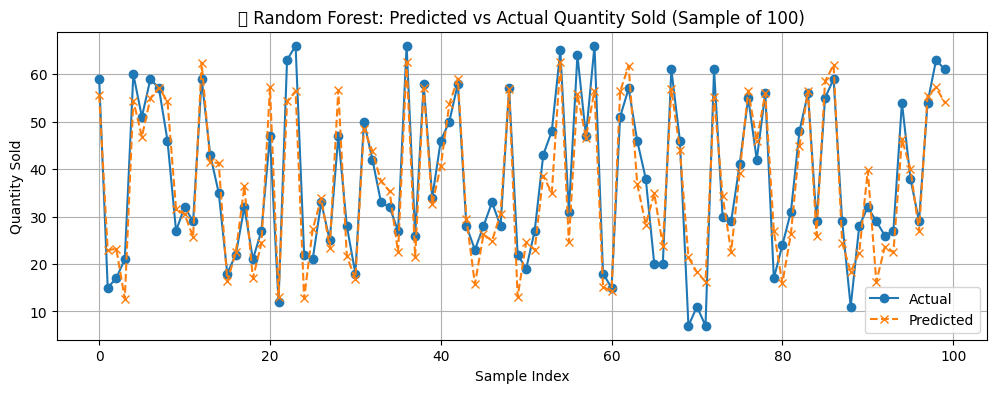

In [23]:
import matplotlib.pyplot as plt

# Plot a small sample of predictions vs actuals
plt.figure(figsize=(12, 4))
plt.plot(y_test.values[:100], label='Actual', marker='o')
plt.plot(rf_preds[:100], label='Predicted', linestyle='--', marker='x')
plt.legend()
plt.title("📊 Random Forest: Predicted vs Actual Quantity Sold (Sample of 100)")
plt.xlabel("Sample Index")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.show()
